# 📈 Unit 2: Time Series Analysis

**Course:** Advanced Machine Learning (AICC 303)  
**Topics Covered:**
*   2.1 Introduction to Time Series Data
*   2.2 Moving Averages, Window Function, Co-integration
*   2.3 Autocorrelation, Auto-regression
*   2.4 ARMA, ARIMA

**Reference:** Hyndman, R.J., & Athanasopoulos, G. (2018) *Forecasting: principles and practice*.

---

## 1. Introduction to Forecasting & Time Series Data

### What is Time Series Data?
A time series is a sequence of observations taken sequentially in time.  
$$ Y = \{y_1, y_2, \dots, y_T\} $$

**Examples:**
*   Daily stock prices
*   Monthly rainfall
*   Quarterly sales figures
*   Website traffic per hour

### Frequency
The frequency of a time series represents how often data is collected.
*   **Daily**: Frequency = 7 (Weekly seasonality) or 365 (Annual seasonality)
*   **Monthly**: Frequency = 12
*   **Quarterly**: Frequency = 4

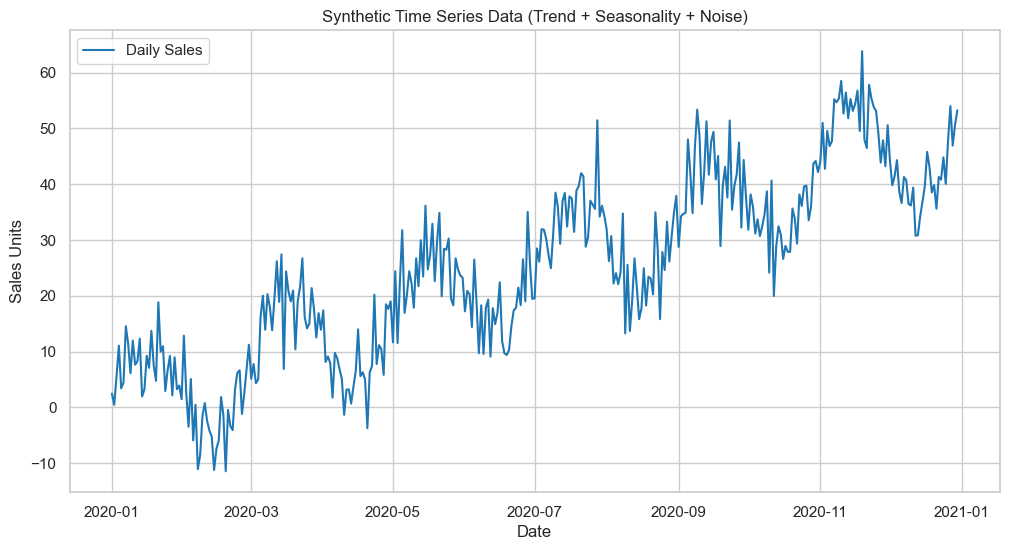

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Setup
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# 1. Create Synthetic Time Series Data
np.random.seed(42)
date_range = pd.date_range(start='2020-01-01', periods=365, freq='D')

# Components: Trend + Seasonality + Noise
trend = np.linspace(0, 50, 365)
seasonality = 10 * np.sin(np.linspace(0, 3.14 * 12, 365))
noise = np.random.normal(0, 5, 365)

y = trend + seasonality + noise

df = pd.DataFrame({'Date': date_range, 'Sales': y})
df.set_index('Date', inplace=True)

# Plot
plt.plot(df.index, df['Sales'], label='Daily Sales', color='tab:blue')
plt.title("Synthetic Time Series Data (Trend + Seasonality + Noise)")
plt.xlabel("Date")
plt.ylabel("Sales Units")
plt.legend()
plt.show()

## 2. Time Series Decomposition

Time series data can often be decomposed into three components:
1.  **Trend ($T_t$):** Long-term increase or decrease in the data.
2.  **Seasonality ($S_t$):** Systematic, calendar-related movements.
3.  **Residual/Error ($R_t$):** Random fluctuations (Noise).

**Additive Model:** $y_t = T_t + S_t + R_t$  
**Multiplicative Model:** $y_t = T_t \times S_t \times R_t$

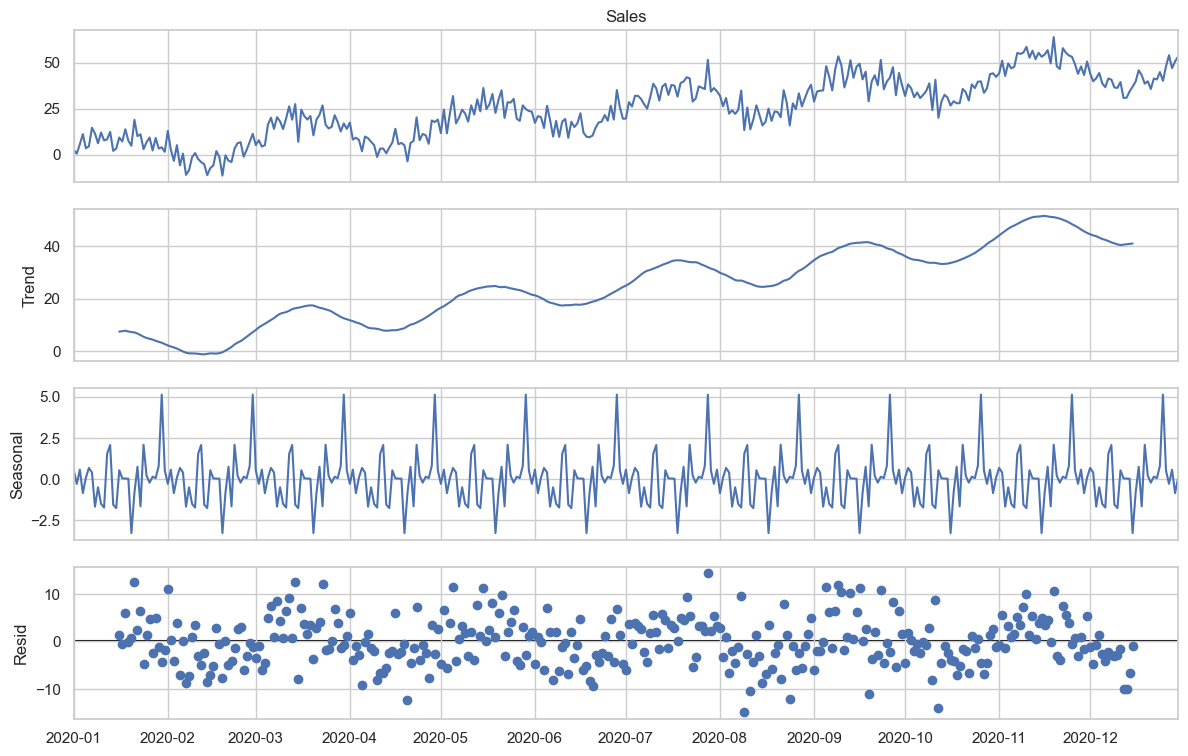

In [2]:
# Decompose the synthetic data
# We use 'additive' because the seasonality amplitude stays constant.
result = seasonal_decompose(df['Sales'], model='additive', period=30)  # Assuming monthly pattern roughly

fig = result.plot()
fig.set_size_inches(12, 8)
plt.show()

## 3. The Forecaster's Toolbox

### 3.1 Moving Averages (MA)
Moving averages smooth out noise to reveal the underlying trend.  
$$ \hat{T}_t = \frac{1}{m} \sum_{j=-k}^{k} y_{t+j} $$

**Window Function:** The size of the window ($m$) determines the smoothness.

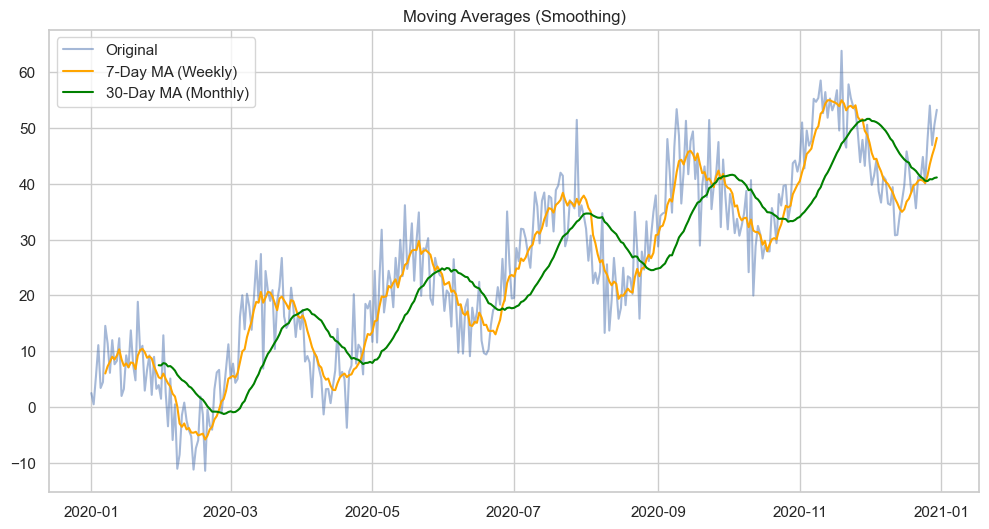

In [3]:
# Calculate Moving Averages
df['MA_7'] = df['Sales'].rolling(window=7).mean()
df['MA_30'] = df['Sales'].rolling(window=30).mean()

plt.figure(figsize=(12, 6))
plt.plot(df['Sales'], label='Original', alpha=0.5)
plt.plot(df['MA_7'], label='7-Day MA (Weekly)', color='orange')
plt.plot(df['MA_30'], label='30-Day MA (Monthly)', color='green')
plt.title("Moving Averages (Smoothing)")
plt.legend()
plt.show()

### 3.2 Autocorrelation (ACF)
Measures the correlation between the time series and a lagged version of itself.
*   **Lag 1:** Correlation between $y_t$ and $y_{t-1}$.
*   **Lag $k$:** Correlation between $y_t$ and $y_{t-k}$.

If data has seasonality of period $S$, ACF will show peaks at lags $S, 2S, 3S...$.

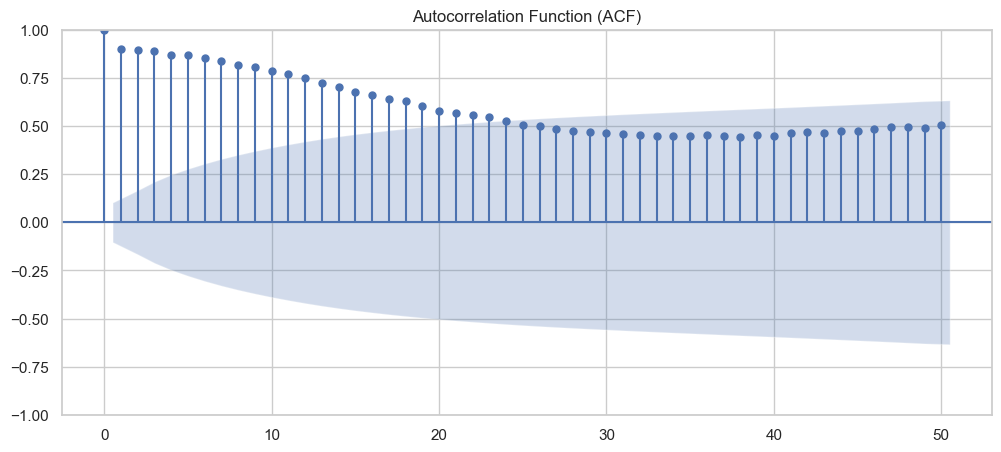

In [4]:
# Plot ACF
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(df['Sales'], lags=50, ax=ax)
plt.title("Autocorrelation Function (ACF)")
plt.show()

# Interpretation: 
# Slow decay indicates a Trend.
# Wavy pattern signifies Seasonality.

## 4. Making Time Series Stationary

Most statistical forecasting methods (like ARIMA) assume **Stationarity**.

**Stationarity Definition:**
A time series is stationary if its statistical properties (mean, variance, autocorrelation) do not change over time.  
*   Constant Mean (No Trend)
*   Constant Variance

### 4.1 Differencing
To make data stationary, we compute the differences between consecutive observations.
$$ y'_t = y_t - y_{t-1} $$

### 4.2 Augmented Dickey-Fuller (ADF) Test
A statistical test to check stationarity.
*   **Null Hypothesis ($H_0$):** Series is Non-Stationary.
*   **p-value < 0.05:** Reject $H_0$ → Series is Stationary.

Augmented Dickey-Fuller Test: Original Data
ADF Statistic : -1.7324258937078334
p-value : 0.41448784511617404
# Lags Used : 12
# Observations : 352
Weak evidence against null hypothesis, time series is non-stationary.


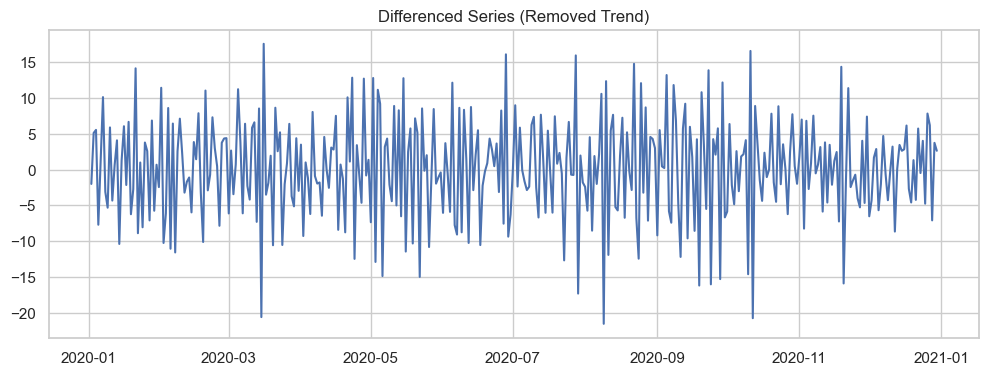

Augmented Dickey-Fuller Test: Differenced Data
ADF Statistic : -3.873601683945682
p-value : 0.0022379461448400776
# Lags Used : 11
# Observations : 352
Strong evidence against the null hypothesis, reject H0. Data is Stationary.


In [5]:
def augmented_dickey_fuller_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    for value, label in zip(result, labels):
        print(label + ' : ' + str(value))
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis, reject H0. Data is Stationary.")
    else:
        print("Weak evidence against null hypothesis, time series is non-stationary.")
        
augmented_dickey_fuller_test(df['Sales'], "Original Data")

# Apply Differencing
df['Sales_Diff'] = df['Sales'].diff()
plt.figure(figsize=(12, 4))
plt.plot(df['Sales_Diff'])
plt.title("Differenced Series (Removed Trend)")
plt.show()

augmented_dickey_fuller_test(df['Sales_Diff'], "Differenced Data")

## 5. ARIMA Models

**ARIMA(p, d, q)** stands for:
*   **AR (Auto-Regressive, $p$):** Lags of the *dependent* variable.
*   **I (Integrated, $d$):** Number of differences required to make it stationary.
*   **MA (Moving Average, $q$):** Lags of the *error terms* (residuals).

### 5.1 Auto-Regressive (AR)
Forecasts the variable using a linear combination of past values.
$$ y_t = c + \phi_1 y_{t-1} + \dots + \phi_p y_{t-p} + \varepsilon_t $$

### 5.2 Moving Average (MA)
Forecasts using a linear combination of past forecast errors.
$$ y_t = c + \varepsilon_t + \theta_1 \varepsilon_{t-1} + \dots + \theta_q \varepsilon_{t-q} $$

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                  365
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1145.035
Date:                Wed, 14 Jan 2026   AIC                           2296.069
Time:                        16:03:17   BIC                           2307.761
Sample:                    01-01-2020   HQIC                          2300.716
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1551      0.081     -1.907      0.057      -0.314       0.004
ma.L1         -0.5614      0.071     -7.941      0.000      -0.700      -0.423
sigma2        31.5620      2.374     13.297      0.0

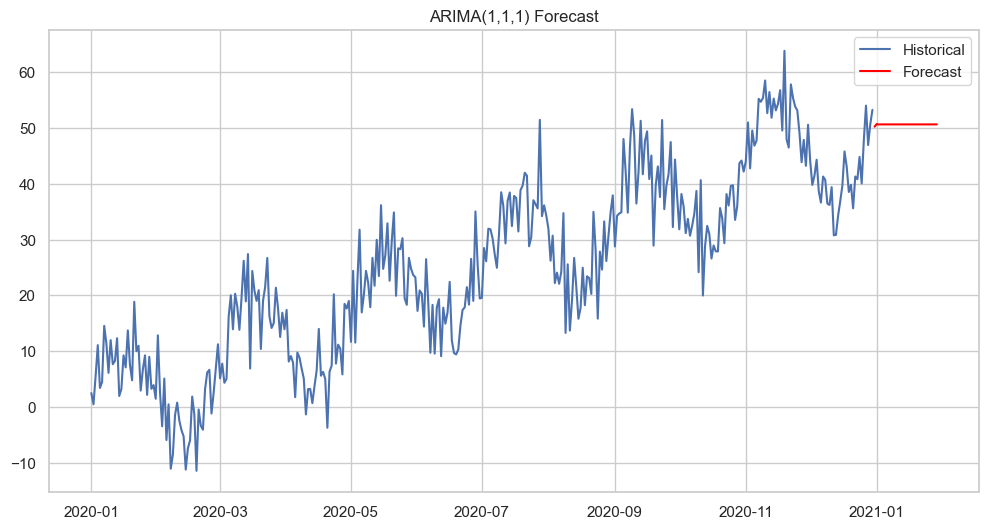

In [6]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA(1, 1, 1) Model
# Order = (p, d, q)
model = ARIMA(df['Sales'], order=(1, 1, 1))
model_fit = model.fit()

print(model_fit.summary())

# Forecast
forecast_steps = 30
forecast = model_fit.forecast(steps=forecast_steps)

# Plot Forecast
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Sales'], label='Historical')
plt.plot(pd.date_range(df.index[-1], periods=forecast_steps+1, freq='D')[1:], forecast, label='Forecast', color='red')
plt.title("ARIMA(1,1,1) Forecast")
plt.legend()
plt.show()

### 6. Evaluating Forecast Accuracy

Common metrics:
1.  **MAE (Mean Absolute Error):** Average of absolute errors.
2.  **RMSE (Root Mean Squared Error):** Penalizes large errors more.
3.  **MAPE (Mean Absolute Percentage Error):** Percentage error (interpretable).

$$ e_t = y_t - \hat{y}_t $$

c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 16.15
RMSE: 17.97


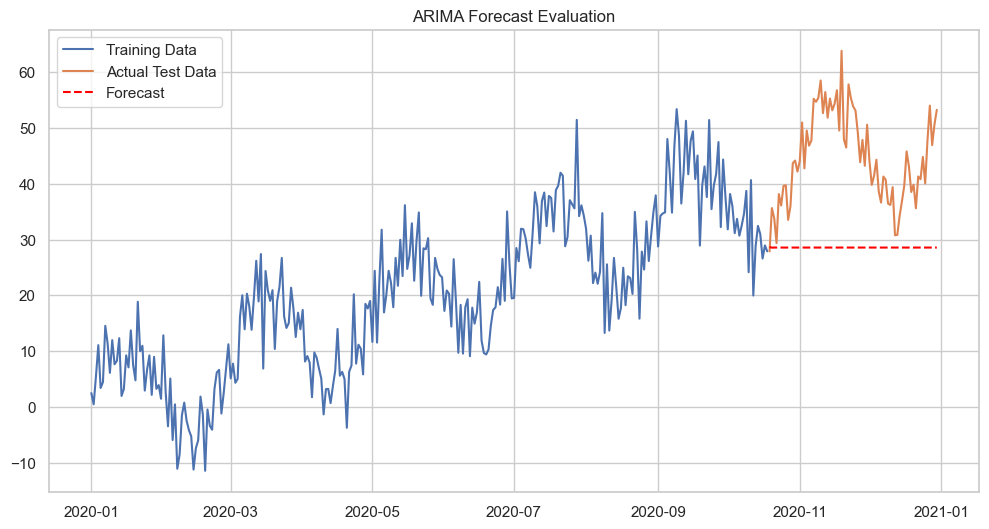

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Let's split train/test
train_size = int(len(df) * 0.8)
train, test = df['Sales'][0:train_size], df['Sales'][train_size:]

# Retrain on train set
model_train = ARIMA(train, order=(1, 1, 1))
model_fit_train = model_train.fit()

# Forecast on test set
predictions = model_fit_train.forecast(steps=len(test))
predictions.index = test.index

# Evaluate
mae = mean_absolute_error(test, predictions)
rmse = np.sqrt(mean_squared_error(test, predictions))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Plot
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Actual Test Data')
plt.plot(predictions, label='Forecast', color='red', linestyle='--')
plt.title("ARIMA Forecast Evaluation")
plt.legend()
plt.show()

---